# Probabilistic error reduction (PER) and virtual ZNE

## Overview of PEC

**Probabilistic error cancellation** (PEC) is an error mitigation method (K. Temme et al., Phys. Rev. Lett., 2017 and Y. Li and S. Benjamin, Phys. Rev. X, 2017). Its practical implementation can be decomposed in the following 4 tasks:

 - **Task 1: Expanding an <span style="color:red"> ideal gate </span> as linear combination of implementable noisy gates.**
 - **Task 2: Sampling an implementable gate from the representation of an <span style="color:red"> ideal gate </span>.**
 - **Task 3: Sampling an implementable circuit from the representation of an <span style="color:red"> ideal circuit </span>.**
 - **Task 4: Infer an <span style="color:red"> ideal expectation value </span> from the noisy execution of the sampled circuits.**

## Probabilistic Error Reduction (PER) = Virtual Noise Scaling

The idea of **Probabilistic error reduction** is to represent **less noisy gates**,  instead of representing ideal gates (PEC). The motivation is a reduction of the sampling overhead. Indeed, reducing the noise is easier (in terms of representation negativity) compared to a complete noise cancellation.

 - **Task 1: Expanding a <span style="color:red"> less noisy gate </span> as linear combination of implementable noisy gates.**
 - **Task 2: Sampling an implementable gate from the representation of a <span style="color:red"> less noisy gate </span>.**
 - **Task 3: Sampling an implementable circuit from the representation of a <span style="color:red"> less noisy circuit </span>.**
 - **Task 4: Infer a <span style="color:red"> less noisy expectation value </span> from the noisy execution of the sampled circuits.**

## Note
The full execution this notebook may require a large amount of time. If you are only interested in reproducing the figure of the paper without re-executing all the simulations, you can set `RUN_SIMULATION = False`. In this case pre-simulated results will be used and visualized.

Alternatively, another way of reducing the execution time of the full notebook (at the cost of less accurate results) is to reduce the value of `num_samples`.

In [1]:
RUN_SIMULATION = False
SAVE_NOTEBOOK_SESSION = False  # If True this notebook will overwrite a previously saved session.
num_samples = 50000  # Set to 50000 to repdouce the results of the paper. Irrelevant if RUN_SIMULATION is False.
batch_size = 2000 # Set to  2000 to repdouce the results of the paper. Irrelevant if RUN_SIMULATION is False.
if num_samples % batch_size:
    raise ValueError("num_samples must be a multiple of batch_size")

In [2]:
import time
from functools import partial
import numpy as np

# Set a seed only if there is interest in reproducibility. Otherwise one can comment next line.
np.random.seed(0)
rnd_state = np.random.RandomState(0)

from matplotlib import pyplot as plt
plt.rcParams.update({"font.family": "serif", "font.size": 14, 'text.latex.preamble': r'\usepackage{amsmath,amssymb,bm,physics,lmodern}'})

# This is for loading or saving a notebook session. If unnecessary, it can be commented.
import dill

from cirq import LineQubit, Circuit, X, DensityMatrixSimulator, depolarize

from mitiq.benchmarks import generate_rb_circuits
from mitiq import pec
from mitiq.pec.representations.depolarizing import represent_operations_in_circuit_with_local_depolarizing_noise
from mitiq import zne

from mitiq.benchmarks import generate_rb_circuits
from mitiq.pec.sampling import sample_circuit

## Expanding a _less noisy_ gate as linear combination of implementable noisy gates

We define the noise scaled gates as $G^{(\lambda)}$, where $\lambda$ is the noise scale factor.

For example, for a depolarizing channel $\mathcal E_{\epsilon}$ of hardware strength $\epsilon$:
$$ \mathcal E_\epsilon (\rho) = (1 - \epsilon ) \rho   + \epsilon I/2 ,$$

we could define a noise-scaled gate as:

$$ G^{(\lambda)} = \mathcal E_\epsilon^{(\lambda)} \circ G (\rho) 
    =  \mathcal E_{\lambda \epsilon} \circ G (\rho). $$
   

In standard PEC, one usually looks for a quasi-probability representation of the following type $G^{(\lambda=0)} = \alpha_1 G_1^{(\lambda=1)}  + \alpha_2 G_2^{(\lambda=1)} + \dots .$

In PER instead we just require the left-hand-side to be less noisy compared to the implementable gates on the right-hand side. So we look for the following representation type: 

$$G^{(\lambda)} = \alpha_1 G_1^{(\lambda=1)}  + \alpha_2 G_2^{(\lambda=1)} + \dots,$$

where $0 < \lambda < 1$ and $\{\alpha_j\}$ are real coefficients.

The **explicit decomposition for a depolarizing channel** can be easily obtained as:

For 

$$ \tilde G =\mathcal E \circ G  \quad 
\text{where,}\quad \mathcal E(\rho) =  (1 - \epsilon ) \rho   + \epsilon I/2 ,$$

then, it is easy to show (for $\lambda=0$ see Temme, Bravyi, Gambetta, 2017 or Tagagi 2020) that the following decomposition holds **for any single-qubit gate $G$**:

$$ G^{(\lambda)}  = \alpha_1 G_1^{(\lambda=1)} + \alpha_2 G_2^{(\lambda=1)} + \alpha_3 G_3^{(\lambda=1)} + \alpha_4 G_4^{(\lambda=1)} $$

where,
$$\alpha_1 =\left(1 + \frac{3}{4} \frac{\epsilon \color{red}{(1-\lambda)}}{1- \epsilon} \right ), \qquad G_1^{(\lambda=1)} = \mathcal E_\epsilon \circ  G$$

$$\alpha_2 =- \frac{1}{4}\frac{\epsilon \color{red}{(1-\lambda)}}{1- \epsilon} , \qquad  G_2^{(\lambda=1)} = \mathcal E_\epsilon \circ  X \circ G$$

$$\alpha_3 =-\frac{1}{4}\frac{\epsilon \color{red}{(1-\lambda)}}{1- \epsilon} , \qquad  G_3^{(\lambda=1)} = \mathcal E_\epsilon \circ  Y \circ G$$

$$\alpha_4 =- \frac{1}{4}\frac{\epsilon \color{red}{(1-\lambda)}}{1- \epsilon} , \qquad  G_4^{(\lambda=1)}  = \mathcal E_\epsilon \circ  Z \circ G$$


## Note

The PER distribution can also be written as the PEC distribution for a smaller value of the noise parameter.

$$\text{PER distrib. } \alpha_j(\epsilon, \lambda) = \alpha_j(   \dfrac{\epsilon (1 - \lambda)}{1- \lambda \epsilon}, 0 ) 
= \text{PEC distrib for } \epsilon' =\frac{\epsilon(1 - \lambda)}{1- \lambda \epsilon}. $$

In other words, if one applies standard PEC with a representation based on $\epsilon'$, then one is effectively scaling the noise by $\lambda$.

This motivates the following functions.

## Define `mitiq.representations` for probabilistic error reduciton 

In [3]:
def epsilon_to_epsilon_prime(epsilon, scale_factor):
    return epsilon * (1 - scale_factor) / (1 - scale_factor * epsilon)

# noise_level = p = 3/4 epsilon  [ lambda_max  4 /3 p = 1  ==> lambda_max = 3 / (4 p)
def p_to_p_prime(p, scale_factor):
    return p * (1 - scale_factor) / (1 - (4 / 3) * scale_factor * p)


from mitiq.pec.representations import (
    represent_operation_with_local_depolarizing_noise,
    represent_operations_in_circuit_with_local_depolarizing_noise,
)

def represent_noise_scaled_operation_with_local_depolarizing_noise(operation, base_noise, scale_factor: float):
    noise_level_prime = p_to_p_prime(base_noise, scale_factor)
    return represent_operation_with_local_depolarizing_noise(operation, noise_level_prime)
    
def represent_noise_scaled_operations_in_circuit_with_local_depolarizing_noise(ideal_circuit, base_noise, scale_factor: float):
    noise_level_prime = p_to_p_prime(base_noise, scale_factor)
    return represent_operations_in_circuit_with_local_depolarizing_noise(ideal_circuit, noise_level_prime)
    

In [4]:
base_noise = 0.1
scalre_factors = np.arange(0, min(2, 3 / (4 * base_noise)), 0.01)

q = LineQubit(1)
x_op = Circuit(X(q))

x_rep = represent_noise_scaled_operation_with_local_depolarizing_noise(
    x_op, base_noise=base_noise, scale_factor=0,
)
print(x_rep)

1: ───X─── = 1.115*1: ───X───-0.038*1: ───X───X───-0.038*1: ───X───Y───-0.038*1: ───X───Z───


The representation above is equal to the standard PEC representation. The opposite limit is the following.

In [5]:
x_rep = represent_noise_scaled_operation_with_local_depolarizing_noise(
    x_op, base_noise=base_noise, scale_factor=1,
)
print(x_rep)

1: ───X─── = 1.000*1: ───X───


Where noise is not reduced, and one simply avoid sampling.

Let us plot the one-norm $\gamma=\sum_j |\alpha_j|$ of the distribution as a function of the noise scale factor.

## Analysis of the sampling cost for probabilistic error reduction

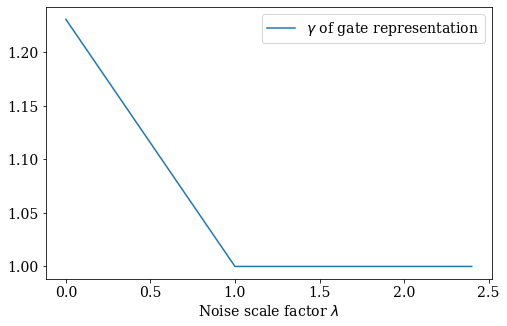

In [6]:
base_noise = 0.1
lambda_max = 3.0 / (4.0 * base_noise)
scale_factors = np.arange(0,  lambda_max / 3, 0.2)

norms = [represent_noise_scaled_operation_with_local_depolarizing_noise(
    Circuit(X(q)), base_noise=base_noise, scale_factor=s,
).norm for s in scale_factors]

plt.figure(figsize=(8, 5))
plt.plot(scale_factors, norms, label="$\gamma$ of gate representation")
plt.xlabel("Noise scale factor")
plt.xlabel("Noise scale factor $\lambda$")
plt.legend()
plt.show()

For a full circuit, the overhead (one-norm) decreases exponentially with respect to the scale factor.

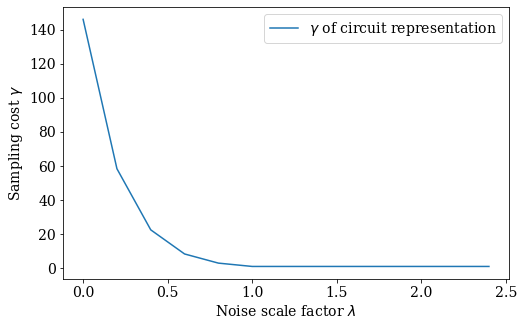

In [7]:
num_qubits = 1
num_cliffords = 10
ideal_circuit = generate_rb_circuits(n_qubits=num_qubits, num_cliffords=num_cliffords, trials=1)[0]

norms = []
for s in scale_factors:
    representations = represent_noise_scaled_operations_in_circuit_with_local_depolarizing_noise(
        ideal_circuit, base_noise=base_noise, scale_factor=s,
    )
    # Evaluate the 1 norm of the quasi-probability of the full circuit
    _, _, norm = sample_circuit(ideal_circuit, representations)
    norms.append(norm)

plt.figure(figsize=(8, 5))
plt.plot(scale_factors, norms, label="$\gamma$ of circuit representation")
plt.legend()
plt.xlabel("Noise scale factor $\lambda$")
plt.ylabel("Sampling cost $\gamma$")
plt.show()

## Defining a noisy executor

We define a function which executes a circuit with depolarizing noise and returns an expectation value (in this example it corresponds to the probability of finding all qubits in the ground state).

In [8]:
SIMULATOR = DensityMatrixSimulator()

def noisy_executor_shots(circ: Circuit, base_noise, shots: int = 0) -> float:
    """Simulates a circuit with depolarizing noise and returns the expectation value
    of the projector on the ground state |00...><00...|.
    """ 
    circuit = circ.with_noise(depolarize(base_noise))
    rho = SIMULATOR.simulate(circuit).final_density_matrix
    expectation = np.real(rho[0, 0])
    
    if shots == 0:
        # Return exact expectation value
        return expectation
    else:
        # Simulate fake shot noise when "shots" is nonzero
        fake_results = np.random.binomial(1, expectation, size=shots)
        return np.average(fake_results)

 # STEP 1: Probabilistc error reduction

In [9]:
if RUN_SIMULATION:
    base_noise = 0.01
    num_cliffords = 20
    ideal_circuit = generate_rb_circuits(n_qubits=1, num_cliffords=num_cliffords, trials=1)[0]
    shots = 1

    scale_factors = np.linspace(0, 1, 11)
    noise_scaled_values =[noisy_executor_shots(ideal_circuit, base_noise * s) for s in scale_factors]

    per_values = []
    per_all_samples = []

    init_time = time.time()
    for scale_factor in scale_factors:

        # Build PER representations
        per_representations = represent_noise_scaled_operations_in_circuit_with_local_depolarizing_noise(
            ideal_circuit=ideal_circuit,
            base_noise=base_noise,
            scale_factor=scale_factor,
        )

        # run PER
        _per_value, _per_data = pec.execute_with_pec(
            ideal_circuit,
            executor=partial(noisy_executor_shots, base_noise=base_noise, shots=shots),
            representations=per_representations,
            num_samples=num_samples,
            full_output=True,
        )
        per_values.append(_per_value)
        per_all_samples.append(np.array(_per_data["unbiased_estimators"]))

        print(f"Expectation value with PER, (virtual scale_factor={scale_factor:.2f}): {_per_value:.5f}")

    per_total_time = time.time() - init_time
    print("Total PER execution time (seconds):", round(per_total_time))
else:
    # Load notebook session with pre-executed results from a .db file
    dill.load_session('probabilistic_error_reduction_session.db')
    

## Print all parameters to log their value in the notebook

In [10]:
print("PROBLEM PARAMETERS")
print("num_cliffords:", num_cliffords)
print("Circuit:", ideal_circuit)
print("Number of ideal gates:", len(list(ideal_circuit.all_operations())))
print("Base noise:", base_noise)
print("Shots:", shots)
print("Num samples", num_samples)
print("Noise scale factors", scale_factors)
print("")
print("Unmitigated expectation value (lambda=1):", noisy_executor_shots(ideal_circuit, base_noise))
print("Theoretical noise scaled values:", noise_scaled_values)
print("Ideal expectation value (lambda=0):", noisy_executor_shots(ideal_circuit, base_noise=0))
print("PER values:", per_values)

PROBLEM PARAMETERS
num_cliffords: 20
Circuit: 0: ───Y───X^0.5───X^0.5───Y^0───Y^-0.5───X^0.5───Y^0.5───Y^0.5───X^0───Y───X───X───Y^0───Y───X^-0.5───Y^0.5───X^-0.5───Y^0.5───X^0.5───Y───X───Y^0.5───X^0───Y^-0.5───X^-0.5───Y^0.5───Y───X^-0.5───X^0.5───Y^0.5───Y^0.5───X^-0.5───X^-0.5───Y^0.5───X───Y^0───X^0.5───Y^0.5───Y───X───X^0.5───Y^0───Y^-0.5───X^0───
Number of ideal gates: 44
Base noise: 0.015
Shots: 1
Num samples 50000
Noise scale factors [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]

Unmitigated expectation value (lambda=1): 0.70554835
Theoretical noise scaled values: [1.0, 0.9578391, 0.919159, 0.88368267, 0.85114276, 0.8213057, 0.79395175, 0.76887625, 0.745898, 0.72484046, 0.70554835]
Ideal expectation value (lambda=0): 1.0
PER values: [0.9935836102218324, 0.9667779624511009, 0.9055407889815017, 0.8815179648841923, 0.8525116817046562, 0.826386401279865, 0.792245045087265, 0.7681267349940551, 0.7450083800782984, 0.7286053243702733, 0.7049]


## Data analysis

To estimate the statistical distribution of the mitigated results, all the samples are divided into batches of equal size (batch_size). The results associated to all batches are combined to get the average error mitigated expectation value and its statistical distribution.

In [11]:
if not RUN_SIMULATION:
    batch_size = 2000 # Set to  2000 to repdouce the results of the paper. Irrelevant if RUN_SIMULATION is False.

if num_samples % batch_size:
    raise ValueError("num_samples must be a multiple of batch_size")
    
per_all_sub_means = []
for scale_factor, _per_samples in zip(scale_factors, per_all_samples):

    per_samples_subsets = _per_samples.reshape((num_samples // batch_size, batch_size))
    per_sub_means = np.mean(per_samples_subsets, axis=1)
    per_all_sub_means.append(per_sub_means)
    
labels = [f"{s:.2f}" for s in scale_factors]

# Visualize PER

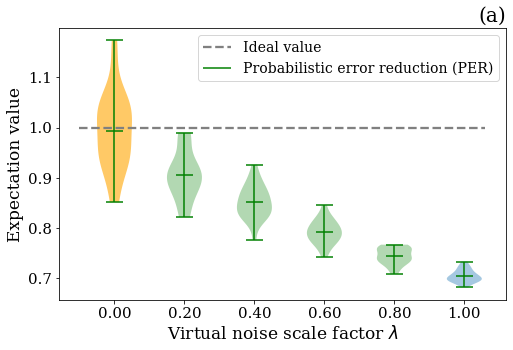

In [12]:
plt.rcParams.update({"font.family": "serif", "font.size": 14})
axis_title_size = 17

few_y = per_all_sub_means[::2]
few_labels = labels[::2]
fig_a = plt.figure(figsize=(8, 5))


violin_parts_per = plt.violinplot(few_y, showmeans=True)

# Change facecolor of violins
for pc in violin_parts_per["bodies"]:
    pc.set_facecolor("green")
    #pc.set_edgecolor('green')

# Set color of PEC
violin_parts_per["bodies"][0].set_facecolor("orange")
violin_parts_per["bodies"][0].set_alpha(0.6)

# Set color of unmitigated
violin_parts_per["bodies"][-1].set_facecolor("#1f77b4")
violin_parts_per["bodies"][-1].set_alpha(0.4)

# Change color of edges
for partname in ("cbars","cmins","cmaxes","cmeans"):
    vp = violin_parts_per[partname]
    vp.set_edgecolor("green")
    #vp.set_linewidth(1.5)

plt.title("(a)", fontsize = 20, position=(0.97, 0.0))
plt.hlines(1, 0.5, len(few_y) + 0.3, color="Gray", alpha=1, linestyle="dashed", label="Ideal value", linewidth=2.3)
plt.hlines(1, 0.5, 0.5, color="green", alpha=1, label="Probabilistic error reduction (PER)")
plt.ylabel("Expectation value", size=axis_title_size)

tick_label_size = 15 
#few_labels[0]=few_labels[0] + "\n (PEC)"
#few_labels[-1]=few_labels[-1] + "\n (Unmitig.)"
plt.xticks(np.array(range(1, len(few_y) + 1)), few_labels, size=tick_label_size)
plt.yticks(size=tick_label_size)
plt.xlabel("Virtual noise scale factor $\lambda$", size=axis_title_size)
plt.legend()

plt.show()

fig_a.savefig("per.pdf")

# Step 2: Virtual ZNE

In [13]:
extrapolation_order = 1
# Select the third scale factor and the last one (i.e. the unmitigated result)
selected_indeces =[2, len(scale_factors) - 1]
zne_scale_factors = [scale_factors[j] for j in selected_indeces]
selected_sub_means_list = np.array([per_all_sub_means[j] for j in selected_indeces])

# Direct evaluation 
expvalues_average_list = [np.mean(per_sub_means) for per_sub_means in selected_sub_means_list]
zne_value = zne.PolyFactory.extrapolate(zne_scale_factors, expvalues_average_list, order=extrapolation_order)

# Multiple evaluations for each batch of samples
zne_sub_values = []
for sub_j in range(num_samples // batch_size):
    sub_expvalues = selected_sub_means_list[:, sub_j]
    zne_sub_values.append(
        zne.PolyFactory.extrapolate(zne_scale_factors, sub_expvalues, order=extrapolation_order)
    )
print("The following results should be equal.")
print("Expectation value with virtual ZNE (average of sub values)", np.mean(zne_sub_values))
print("Expectation value with virtual ZNE (direct)", zne_value)

## Data analysis

y_values = [zne_sub_values]
mitigation_labels = [f"Virtual ZNE \n $\lambda \in $ {set(np.round(zne_scale_factors, 2))}"]

y_values.append(per_all_sub_means[0])
mitigation_labels.append("PEC \n $\lambda=0$")

for j in selected_indeces[:-1]:
    y_values.append(per_all_sub_means[j]) 
    mitigation_labels.append(f"PER \n $\lambda=${scale_factors[j]:.2f}")

y_values.append(per_all_sub_means[-1])
mitigation_labels.append("Unmitigated \n $\lambda=1$")   

The following results should be equal.
Expectation value with virtual ZNE (average of sub values) 0.9557009862268775
Expectation value with virtual ZNE (direct) 0.9557009862268777


# Visualize virtual ZNE

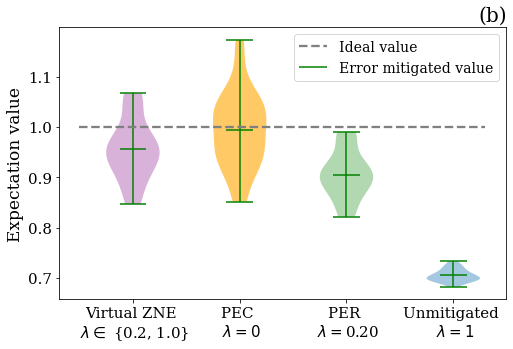

In [14]:
plt.rcParams.update({"font.family": "serif", "font.size": 14})
axis_title_size = 17

fig_b= plt.figure(figsize=(8, 5))
violin_parts_methods = plt.violinplot(y_values, showmeans=True)


# Change facecolor of violins
for pc in violin_parts_methods["bodies"]:
    pc.set_facecolor("green")
    #pc.set_edgecolor('green')
    
# Change color of edges
for partname in ("cbars","cmins","cmaxes","cmeans"):
    vp = violin_parts_methods[partname]
    vp.set_edgecolor("green")
    #vp.set_linewidth(1.5)

# Set color of virtual ZNE
violin_parts_methods["bodies"][0].set_facecolor("purple")

# Set color of PEC
violin_parts_methods["bodies"][1].set_facecolor("orange")
violin_parts_methods["bodies"][1].set_alpha(0.6)

# Set color of unmitigated
violin_parts_methods["bodies"][-1].set_facecolor("#1f77b4")
violin_parts_methods["bodies"][-1].set_alpha(0.4)


plt.title("(b)", fontsize = 20, position=(0.97, 0.0))
plt.hlines(1, 0.5, len(y_values) + 0.3, color="Gray", alpha=1, linestyle="dashed", label="Ideal value", linewidth=2.3)
plt.hlines(1, 0.5, 0.5, color="green", alpha=1, label="Error mitigated value")

plt.ylabel("Expectation value", size=axis_title_size)

tick_label_size = 15
plt.xticks(range(1, len(y_values) + 1), mitigation_labels, size=tick_label_size)
plt.yticks(size=tick_label_size)

plt.legend()
plt.show()

fig_b.savefig("virtual_zne.pdf")

# Save notebook session

In [15]:
if SAVE_NOTEBOOK_SESSION:
    try:
        del _per_data
    except NameError:
        pass
    dill.dump_session('probabilistic_error_reduction_session.db')
else:
    print("Not saved since SAVE_NOTEBOOK_SESSION is", SAVE_NOTEBOOK_SESSION)

Not saved since SAVE_NOTEBOOK_SESSION is False


In [16]:
import mitiq

mitiq.about()


Mitiq: A Python toolkit for implementing error mitigation on quantum computers
Authored by: Mitiq team, 2020 & later (https://github.com/unitaryfund/mitiq)

Mitiq Version:	0.10.0dev

Core Dependencies
-----------------
Cirq Version:	0.10.0
NumPy Version:	1.20.1
SciPy Version:	1.4.1

Optional Dependencies
---------------------
PyQuil Version:	2.28.0
Qiskit Version:	0.24.0
Braket Version:	1.5.16

Python Version:	3.7.7
Platform Info:	Linux (x86_64)
